=== Part A: Simple El Farol (predictors) ===
First 20 attendances: [5, 50, 0, 50, 50, 50, 0, 50, 50, 50, 50, 0, 0, 50, 50, 50, 50, 0, 50, 50]
Mean attendance (last 100): 36.50

=== Part B: Discrete-prob RL ===
Mean attendance (final 100): 39.36
Mean chosen p (final 100): 0.792
Per-agent avg chosen p (first 10 agents): [0.784, 0.728, 0.746, 0.82, 0.746, 0.844, 0.682, 0.633, 0.723, 0.637]


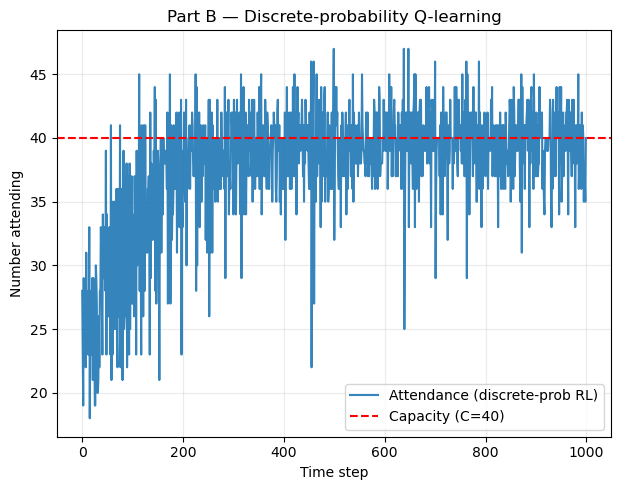

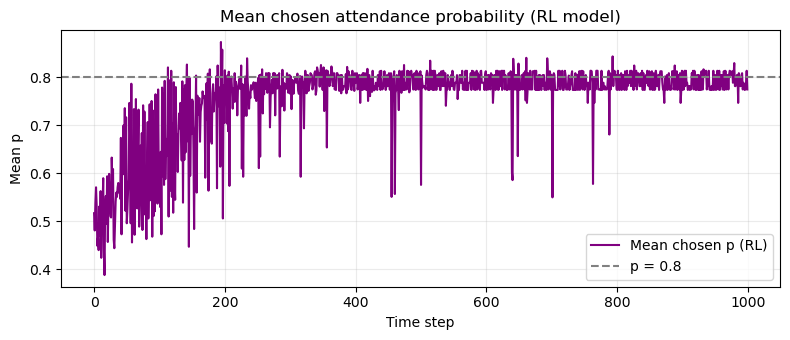

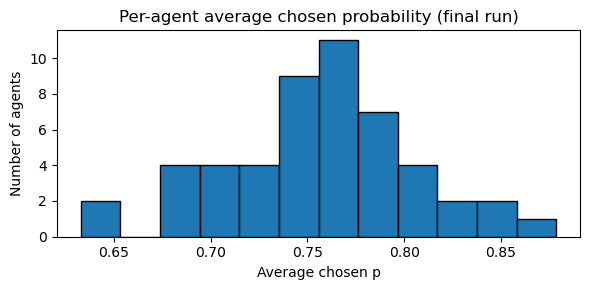

In [58]:
"""
Two simple implementations for the El Farol problem.

Part A: "Original" El Farol (simple inductive predictors / Arthur-style).
Part B: Discrete-probability RL (tabular Q-learning over probability-actions).

Requirements:
    - Python 3.7+
    - numpy, matplotlib (matplotlib optional; only used for simple plots)
Run one part at a time or both.
"""

import random, math
import numpy as np

# ---------------------------------------------------------------------
# PARAMETERS (clear, editable)
# ---------------------------------------------------------------------
# Common
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Game / environment
N = 50   
C_frac = 0.8              # number of agents
C = int(C_frac * N)       # bar capacity (integer number of attendees tolerated)
T = 1000               # number of rounds / time steps

# Payoffs (for reference / optional use)
G = 8.0  # payoff for attending when not overcrowded
S = 2.0  # payoff for staying home
F = 0.1  # payoff for attending when overcrowded (F < S < G)

# Punishment (used in Part B)
rho = 0.1
alpha = 1.3
theta_cap = 1000      # numerical cap for theta
bar_theta = 0.5
beta = 0.5            # aggregate punishment weight

# RL (Part B)
M = 20                # discretization steps: actions = 0..M (p = a / M)
LR = 0.05             # Q-learning rate
GAMMA = 0.8          # discount factor
TAU = 0.05             # softmax temperature
K_INIT = 0.1          # initial Q range
# ---------------------------------------------------------------------


# -------------------------
# Part A: Simple El Farol
# -------------------------
def run_el_farol_predictors(N=N, C=C, T=T, predictor_windows=(1,3,5,10)):
    """
    Simple Arthur-like El Farol:
    - Each agent holds a small set of predictors that forecast next attendance by
      computing moving averages of different window sizes from past attendance series.
    - Each predictor is scored by cumulative squared error; the agent uses the predictor
      with lowest score to forecast next attendance and goes iff forecast < C.
    Returns attendance_time_series, fraction_go_time_series.
    """
    W_list = list(predictor_windows)
    num_predictors = len(W_list)

    # initialize predictor scores (lower is better)
    pred_scores = np.zeros((N, num_predictors), dtype=float)  # sum of squared errors
    # initialize last attendance history with random draws
    A_history = []
    # initial random attendance
    a0 = np.random.binomial(1, 0.1, size=N)
    A0 = a0.sum()
    A_history.append(A0)

    # keep trackers
    attendance_ts = [A0]
    chosen_pred_idx = np.zeros(N, dtype=int)

    # For t >= 1:
    for t in range(1, T):
        A_prev_series = np.array(A_history)  # global series
        forecasts = np.zeros((N, num_predictors), dtype=float)

        # build predictors: moving average of last w values (if not enough history, use mean of available)
        for j, w in enumerate(W_list):
            if len(A_prev_series) < 1:
                base = A_prev_series.mean() if len(A_prev_series) > 0 else C  # fallback
            else:
                # compute moving average of aggregate attendance (not individuals)
                for i in range(N):
                    if len(A_prev_series) >= w:
                        forecasts[i, j] = A_prev_series[-w:].mean()
                    else:
                        forecasts[i, j] = A_prev_series.mean()

        # each agent picks best predictor (lowest cumulative squared error so far)
        for i in range(N):
            chosen = np.argmin(pred_scores[i])
            chosen_pred_idx[i] = chosen
            forecast_i = forecasts[i, chosen]
            # decision rule
            go = 1 if forecast_i < C else 0
            # store decision temporarily
            forecasts[i, :] = forecasts[i, :]  # no-op (we reuse forecasts below)

        # compute actual attendance: each agent uses its chosen predictor to decide
        actions = np.zeros(N, dtype=int)
        for i in range(N):
            chosen = int(chosen_pred_idx[i])
            forecast_i = forecasts[i, chosen]
            actions[i] = 1 if forecast_i < C else 0

        A_t = actions.sum()
        attendance_ts.append(A_t)
        A_history.append(A_t)

        # update predictor scores: each predictor for each agent is scored by squared error of its forecast vs realized A_t
        for i in range(N):
            for j in range(num_predictors):
                err = forecasts[i, j] - A_t
                pred_scores[i, j] += err * err

        # optional: break early if converged (not implemented here)
    attendance_ts = np.array(attendance_ts)
    return attendance_ts


# -------------------------
# Part B: Discrete-probability RL (tabular)
# -------------------------
def softmax(x, tau=1.0):
    z = x / tau
    z = z - np.max(z)
    expz = np.exp(z)
    return expz / expz.sum()


def bin_theta(theta):
    """Simple binning for aggregated Theta for state representation"""
    if theta <= 0:
        return 0
    return min(int(math.log10(theta + 1e-9) + 1), 6)  # small mapping to 0..6


def make_state(A, Theta):
    """State representation: (attendance_bin, theta_bin)"""
    # attendance bin: 0..N (we coarsen by integer attendance)
    a_bin = int(A)  # in [0..N]
    th_bin = bin_theta(Theta)
    return (a_bin, th_bin)


def run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA, tau=TAU,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT):
    """
    Discrete-probability RL:
    - Each agent selects index a_idx in 0..M representing p = a_idx / M.
    - Agent samples attendance ~ Bernoulli(p).
    - Q-learning over state x action_index with softmax selection over actions.
    - Theta_i grows super-linearly when agent consecutively stays home; resets to 0 on attendance.
    """
    # Q-table as dict: state -> np.array length M+1
    Q_tables = [dict() for _ in range(N)]
    # initialize last actual attendance for each agent (used for theta evolution)
    last_actual = np.random.binomial(1, 0.1, size=N)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float)
    Theta = theta_i.sum()

    # random initial Q values
    def q_get(qdict, s):
        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = []
    mean_p_ts = []  # mean chosen probability each step
    # action_counts per agent for summary
    chosen_action_counts = np.zeros((N, M + 1), dtype=int)

    for t in range(T):
        # current state (we use same state for all agents; could be individualized)
        # Use previous aggregate attendance as A_prev; if t==0, random initial A_prev
        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1)
        state = make_state(A_prev, Theta)

        actions = np.zeros(N, dtype=int)   # actual attendances (0/1)
        chosen_idxs = np.zeros(N, dtype=int)

        # each agent selects probability index via softmax over its Q(state)
        for i in range(N):
            qvec = q_get(Q_tables[i], state)
            probs = softmax(qvec, tau=tau)
            idx = np.random.choice(np.arange(M + 1), p=probs)
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1

        # sample actual attendance from chosen probs
        p_vec = chosen_idxs / float(M)
        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i])

        A_t = actions.sum()
        attendance_ts.append(A_t)
        mean_p_ts.append(p_vec.mean())

        # update theta per agent based on consecutive non-attendance
        new_theta = np.zeros_like(theta_i)
        for i in range(N):
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                new_theta[i] = bar_theta
            else:  # attended
                new_theta[i] = 0.0
        theta_i = new_theta
        Theta = float(theta_i.sum())

        # compute per-agent rewards (stage payoff minus aggregate punishment)
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            # stage payoff per earlier definition
            if actions[i] == 1:
                # if others attendance minus self < C -> uncrowded
                others = A_t - 1
                payoff = G if others < C else F
            else:
                payoff = S
            rewards[i] = payoff - beta * Theta

        # Q-learning update for each agent: sample transition (s, a_idx, r, s_next)
        next_state = make_state(A_t, Theta)
        for i in range(N):
            qdict = Q_tables[i]
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i]
            r = rewards[i]
            # Q-learning update
            qvec[aidx] = qvec[aidx] + lr * (r + gamma * np.max(next_qvec) - qvec[aidx])
            qdict[state] = qvec

        # update last_actual
        last_actual = actions.copy()

    attendance_ts = np.array(attendance_ts)
    mean_p_ts = np.array(mean_p_ts)
    return {
        "attendance_ts": attendance_ts,
        "mean_p_ts": mean_p_ts,
        "chosen_action_counts": chosen_action_counts,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables
    }


# -------------------------
# Run simple demonstrations
# -------------------------
if __name__ == "__main__":
    print("=== Part A: Simple El Farol (predictors) ===")
    att_series = run_el_farol_predictors()
    print(f"First 20 attendances: {att_series[:20].tolist()}")
    print(f"Mean attendance (last 100): {att_series[-100:].mean():.2f}")

    print("\n=== Part B: Discrete-prob RL ===")
    res = run_discrete_prob_rl(T=T)  # shorter run for demo
    att = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    print(f"Mean attendance (final 100): {att[-100:].mean():.2f}")
    print(f"Mean chosen p (final 100): {mean_p[-100:].mean():.3f}")
    # show simple histogram of per-agent average chosen probability
    avg_p_per_agent = (res["chosen_action_counts"].dot(np.arange(M + 1))) / (M * res["chosen_action_counts"].sum(axis=1))
    print("Per-agent avg chosen p (first 10 agents):", np.round(avg_p_per_agent[:10], 3).tolist())

    


# ----- 
# Corrected plotting code (paste after the main demo run) 
# -----
import matplotlib.pyplot as plt

# If the demo wasn't executed (e.g., functions imported), run short demos to get data
try:
    att_el = att_series  # from run_el_farol_predictors() in the __main__ block
except NameError:
    print("att_series not found — running run_el_farol_predictors() to produce it.")
    att_el = run_el_farol_predictors(T=T)

try:
    # res was created by run_discrete_prob_rl() in the __main__ block
    res  # just to check existence
    att_rl = res["attendance_ts"]
    mean_probs = res["mean_p_ts"]
except NameError:
    print("res not found — running run_discrete_prob_rl() to produce it.")
    tmp = run_discrete_prob_rl(T=T)
    att_rl = tmp["attendance_ts"]
    mean_probs = tmp["mean_p_ts"]

# Ensure numpy arrays
att_el = np.asarray(att_el)
att_rl = np.asarray(att_rl)
mean_probs = np.asarray(mean_probs)

# Basic plotting: attendance time series side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(att_rl, label="Attendance (discrete-prob RL)", alpha=0.9)
plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
plt.title("Part B — Discrete-probability Q-learning")
plt.xlabel("Time step")
plt.ylabel("Number attending")
plt.legend()
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

# Optional: mean chosen probability (Part B)
plt.figure(figsize=(8, 3.5))
plt.plot(mean_probs, label='Mean chosen p (RL)', color='purple')
plt.axhline(C_frac, color='gray', linestyle='--', label=f'p = {C_frac}')
plt.title("Mean chosen attendance probability (RL model)")
plt.xlabel("Time step")
plt.ylabel("Mean p")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Histogram of per-agent average chosen p 
if "res" in globals() and "chosen_action_counts" in res:
    counts = res["chosen_action_counts"]
    avg_p_per_agent = (counts.dot(np.arange(M + 1))) / (M * counts.sum(axis=1))
    plt.figure(figsize=(6,3))
    plt.hist(avg_p_per_agent, bins=12, edgecolor='black')
    plt.title("Per-agent average chosen probability (final run)")
    plt.xlabel("Average chosen p")
    plt.ylabel("Number of agents")
    plt.tight_layout()
    plt.show()






=== Part A: Original El Farol ===
Mean attendance (last 100): 35.25

=== Part B: Discrete-probability RL ===
Mean attendance (last 100): 25.80
Mean chosen p (last 100): 0.514


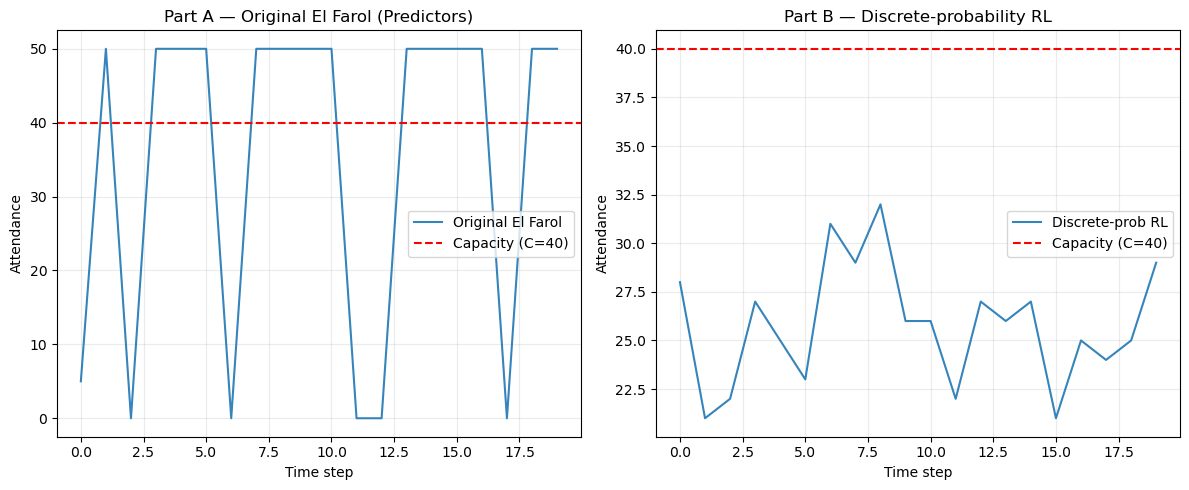

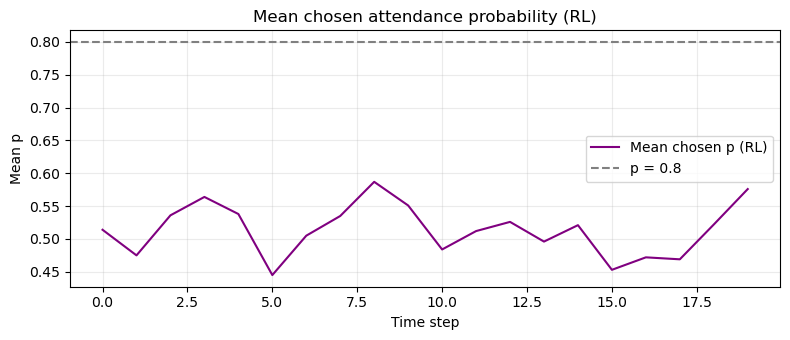

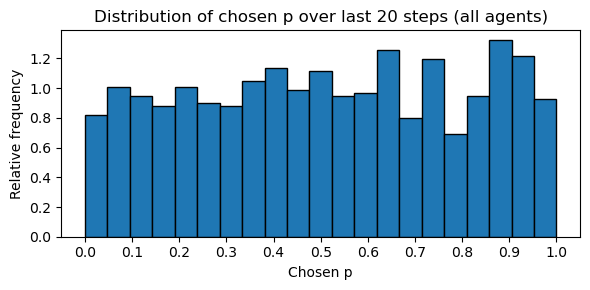

In [78]:
"""
El Farol Bar Problem — Two Simple Implementations

Part A: "Original" El Farol (Arthur-style predictors).
Part B: Discrete-probability Reinforcement Learning (tabular Q-learning).

"""

import random, math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PARAMETERS (clear and editable)
# ---------------------------------------------------------------------
# Common
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Game / environment
N = 50            # number of agents
C_frac = 0.8      # capacity as fraction of population
C = int(C_frac * N)  # bar capacity
T = 20         # number of rounds / time steps

# Payoffs
G = 8.0   # payoff for attending when not overcrowded
S = 2.0   # payoff for staying home
F = 0.1   # payoff for attending when overcrowded

# Theta / punishment parameters (Part B)
rho = 0.1
alpha = 1.3
theta_cap = 1000
bar_theta = 0.5
beta = 0.5

# RL parameters (Part B)
M = 20          # discretization steps: actions = 0..M (p = a/M) there will be M+1 many probability levels cus also 0
LR = 0.05       # Q-learning rate
GAMMA = 0.8     # discount factor
TAU = 0.1      # softmax temperature
K_INIT = 0.1    # initial Q value range
# ---------------------------------------------------------------------


# -------------------------
# Part A: Original El Farol
# -------------------------
def run_el_farol_predictors(N=N, C=C, T=T, predictor_windows=(1, 3, 5, 10)):
    """Arthur-style predictor model."""
    W_list = list(predictor_windows)
    num_predictors = len(W_list)

    pred_scores = np.zeros((N, num_predictors), dtype=float)
    A_history = []
    a0 = np.random.binomial(1, 0.1, size=N)
    A0 = a0.sum()
    A_history.append(A0)

    attendance_ts = [A0]
    chosen_pred_idx = np.zeros(N, dtype=int)

    for t in range(1, T):
        A_prev_series = np.array(A_history)
        forecasts = np.zeros((N, num_predictors), dtype=float)

        for j, w in enumerate(W_list):
            base_val = A_prev_series.mean()
            for i in range(N):
                if len(A_prev_series) >= w:
                    forecasts[i, j] = A_prev_series[-w:].mean()
                else:
                    forecasts[i, j] = base_val

        for i in range(N):
            chosen = np.argmin(pred_scores[i])
            chosen_pred_idx[i] = chosen

        actions = np.zeros(N, dtype=int)
        for i in range(N):
            forecast_i = forecasts[i, chosen_pred_idx[i]]
            actions[i] = 1 if forecast_i < C else 0

        A_t = actions.sum()
        attendance_ts.append(A_t)
        A_history.append(A_t)

        for i in range(N):
            for j in range(num_predictors):
                err = forecasts[i, j] - A_t
                pred_scores[i, j] += err * err

    return np.array(attendance_ts)


# -------------------------
# Part B: Discrete-probability RL
# -------------------------
def softmax(x, tau=TAU):
    #Boltzmann (softmax) policy, which converts Q-values into action probabilities - x is vector of q-values (consites of action and state)
    z = x / tau
    z -= np.max(z) #just numerical stability
    expz = np.exp(z) # Exponential weighting
    return expz / expz.sum() #Normalization constant (sum over all actions)


def bin_theta(theta):
    #Binning θ turns a continuous, potentially huge variable into a small, learnable categorical feature that makes Q-learning practical and stable.
    """Binning for Theta - maps the order of magnitude of theta to an integer “bin”"""
    if theta <= 0:
        return 0
    return min(int(math.log10(theta + 1e-9) + 1), 6) # ensures that the Q-tables has a discrete and hashable keys


def make_state(A, Theta):
    """State representation"""
    a_int = int(A)
    theta_bin = bin_theta(Theta)
    return (a_int, theta_bin)


def run_discrete_prob_rl(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA, tau=TAU,
                         rho=rho, alpha=alpha, beta=beta, bar_theta=bar_theta,
                         theta_cap=theta_cap, k_init=K_INIT):
    """Discrete-probability RL model"""
    Q_tables = [dict() for _ in range(N)] #makes N dicts - each maps the discreate state representet as a Q-vector of length M+1.
    last_actual = np.random.binomial(1, 0.5, size=N) #It represents the previous actions (attendance) of the agents before the simulation begins (i put 50/50)
    theta_i = np.array([bar_theta if a == 0 else 0.0 for a in last_actual], dtype=float) #if agent’s initial action was 0, set theta = bar_theta, else 0.0 for all the N actions in last_actual.
    Theta = theta_i.sum() #just the sum used for payoff

    def q_get(qdict, s):
        #Returns the Q-vector for state s stored in qdict (an agent’s Q-table).
        #If s is absent, initializes a new random Q-vector uniformly in [0, k_init) of length M+1.

        #q_get initialises Q-values randomly in [0, k_init). This introduces stochasticity and exploration early on.

        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    attendance_ts = [] #(list of attendance counts over time),
    mean_p_ts = [] #(mean of chosen probabilities each timestep),
    chosen_action_counts = np.zeros((N, M + 1), dtype=int) #(N x (M+1) counts of how many times each index chosen),
    chosen_history = np.zeros((T, N), dtype=int)  # (T x N array storing chosen indices each time step) KINDA BIG.

    for t in range(T):
        #THE LOOP BEGINS 
        A_prev = attendance_ts[-1] if t > 0 else int(N * 0.1) #previous attendance (use 10% of N as initial attendance at t=0). WHY 0.1
        state = make_state(A_prev, Theta) #RETURNS PREVIAUS STATE AS INTEGER AND THETA (JUST BINED)

        actions = np.zeros(N, dtype=int)
        chosen_idxs = np.zeros(N, dtype=int)

        for i in range(N): # for each player
            qvec = q_get(Q_tables[i], state) #get state representation for player i aka their q-table in a givn state ( stat consisting of prev atendens and theta)
            probs = softmax(qvec, tau=tau) #softmax converts Q-values into a categorical distribution over indices 0..M. Temperature tau controls exploration vs exploitation
            idx = np.random.choice(np.arange(M + 1), p=probs) #idx is the chosen discrete index; stored in chosen_idxs[i] and increments chosen_action_counts[i, idx]. 
            # idx is a random choice, but weighted by the current Q-values. It’s not purely random; it’s probabilistic action selection guided by the learned Q-values.
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1

        p_vec = chosen_idxs / float(M) #The chosen index is mapped to a probability p = idx / M
        #the intended probability of taking the actual action = 1. Then the agent actually samples action ~ Bernoulli(p).

        for i in range(N):
            actions[i] = np.random.binomial(1, p_vec[i]) #Then action (0 or 1) is sampled for each agent with that probability P.

        chosen_history[t, :] = chosen_idxs  # stores the chosen discrete index for each agent each time step.

        A_t = actions.sum() #SUM OF ACTIONS ALSO ATENTES CUZ 1 AND 0 ARE NICE TO WORK WITH
        attendance_ts.append(A_t) #attendance counts over time (sum of binary actions) USED TO PLOT 
        mean_p_ts.append(p_vec.mean()) #average of the p_vec across agents each timestep.

        # Update theta
        new_theta = np.zeros_like(theta_i)

        for i in range(N): # for all players:
            # If agent did not go now (action==0) and also did not go previously (last_actual==0): 
            # theta increases from prev by rho * prev**alpha, capped by theta_cap. 
            # If prev was 0, it uses bar_theta as starting value. HELP
            if actions[i] == 0 and last_actual[i] == 0:
                prev = theta_i[i] if theta_i[i] > 0 else bar_theta
                new_val = prev + rho * (prev ** alpha)
                new_theta[i] = min(new_val, theta_cap)
            elif actions[i] == 0 and last_actual[i] == 1:
                #If agent did not go now but went previously (last_actual==1), reset theta to bar_theta
                new_theta[i] = bar_theta
            else:
                #If agent just went (action==1), set theta to 0.
                new_theta[i] = 0.0
        theta_i = new_theta #why - I dont get the shape why is it not inside loop i am confution CANT JUST GO INTO REWARD ETHER
        Theta = float(theta_i.sum())

        # Rewards
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                # If an agent chooses to go, payoff depends on how many other agents chose to go:
                # If others < C → payoff = G.
                # If others >= C → payoff = F.
                others = A_t - 1
                payoff = G if others < C else F
            else:
                #If agent chooses 0, payoff is S
                payoff = S
            rewards[i] = payoff - beta * Theta #PLAY with theta - i tried with new_theta[i] but that just destroys the learning

        next_state = make_state(A_t, Theta)
        for i in range(N):
            #the actual q-learning 
            qdict = Q_tables[i] #is the agent’s personal Q-table - The key is the current environment state - The value is the vector of Q-values for all possible discrete actions (M+1 of them).
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i] #this is player i's current indet (could also just be p*M and thik of M as 100 even when it isnt)
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx]) #Standard one-step Q-learning update: Q(s, a) ← Q(s, a) + α [ r + γ max_a' Q(s', a') − Q(s, a) ].
            qdict[state] = qvec #Q-table is updated in-place in Q_tables[i][state]. aka store the updated Q-values qvec for this particular state in the agent’s Q-table
            # the q values can be thought of as: what the agent has learned about which idx (probability of acting) works best in each state. where the state is represented as the atendence as well as the size of theta

        last_actual = actions.copy() #Each last_actual[i] indicates whether agent i was “attending” (1) or “not attending” (0) at the previous time step (t = -1).
        # the .copy just allows you to put new actions next time step and then save them agian ones you are dome

    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_theta": theta_i,
        "final_Q_tables": Q_tables
    }


# -------------------------
# Run both models and plot
# -------------------------
if __name__ == "__main__":
    print("=== Part A: Original El Farol ===")
    att_el = run_el_farol_predictors()
    print(f"Mean attendance (last 100): {att_el[-100:].mean():.2f}")

    print("\n=== Part B: Discrete-probability RL ===")
    res = run_discrete_prob_rl(T=T)
    att_rl = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    print(f"Mean attendance (last 100): {att_rl[-100:].mean():.2f}")
    print(f"Mean chosen p (last 100): {mean_p[-100:].mean():.3f}")

    # ---- PLOTS ----
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(att_el, label="Original El Farol", alpha=0.9)
    plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    plt.title("Part A — Original El Farol (Predictors)")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)

    plt.subplot(1, 2, 2)
    plt.plot(att_rl, label="Discrete-prob RL", alpha=0.9)
    plt.axhline(C, color='r', linestyle='--', label=f'Capacity (C={C})')
    plt.title("Part B — Discrete-probability RL")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Mean chosen probability (RL)
    plt.figure(figsize=(8, 3.5))
    plt.plot(mean_p, label='Mean chosen p (RL)', color='purple')
    plt.axhline(C_frac, color='gray', linestyle='--', label=f'p = {C_frac}')
    plt.title("Mean chosen attendance probability (RL)")
    plt.xlabel("Time step")
    plt.ylabel("Mean p")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of chosen p's in final window
    chosen_hist = res["chosen_history"]
    final_window = T # do spisific numbers to see what happens at what times in the learning
    M = chosen_hist.max()
    w = min(final_window, chosen_hist.shape[0])
    flat_idxs = chosen_hist[-w:, :].flatten()
    p_values = flat_idxs / M

    plt.figure(figsize=(6, 3))
    plt.hist(p_values, bins=M + 1, edgecolor='black', density=True)
    plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
    plt.xlabel("Chosen p")
    plt.ylabel("Relative frequency")
    plt.xticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()


=== Discrete-probability Q-learning (no theta) ===
Mean attendance (last 100): 24.35
Mean chosen p (last 100): 0.502
Mean var(p) (last 100): 0.09036


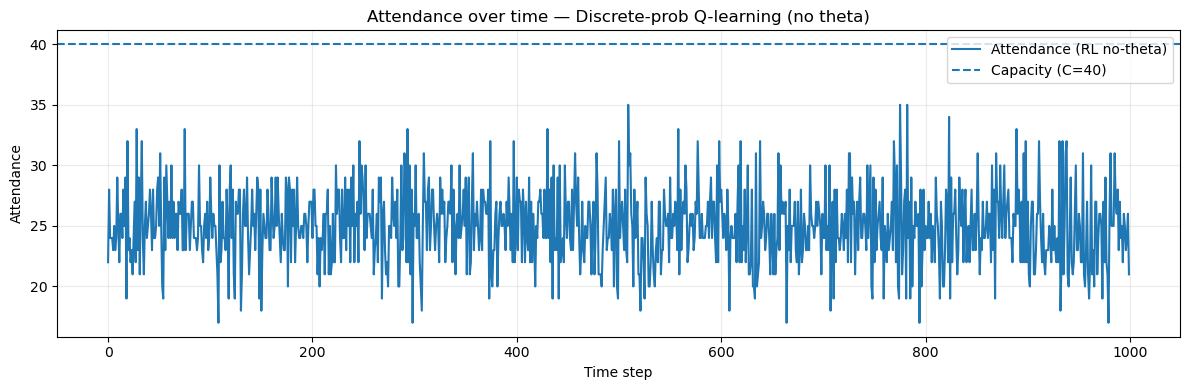

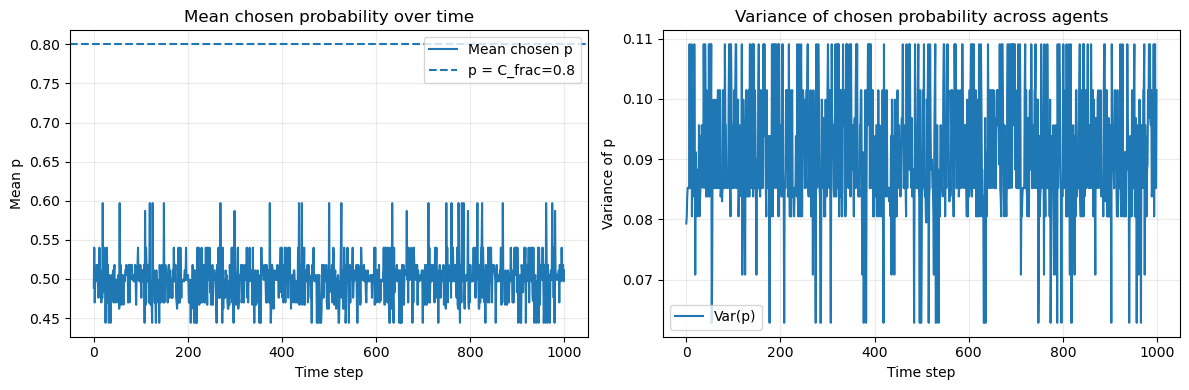

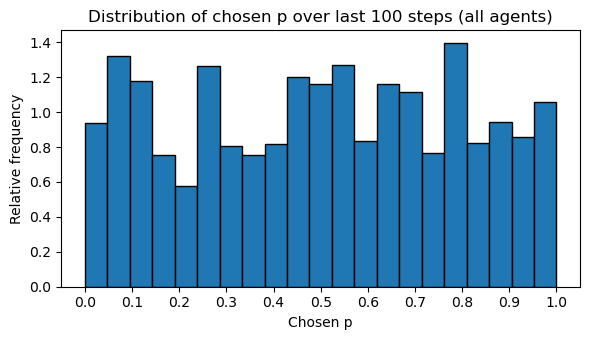

In [ ]:
"""
El Farol — Discrete-probability Q-learning (no theta)

This file replaces the original Arthur-style Part A with the RL-only
model (theta / frustration removed). It keeps the tabular discrete-
probability Q-learning per-agent, records chosen actions, and plots
both attendance and the variance of chosen p across agents over time.

Requirements:
    - Python 3.7+
    - numpy, matplotlib

Run as: python el_farol_rl_no_theta.py
"""

import random
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PARAMETERS
# ---------------------------------------------------------------------
SEED = 69
np.random.seed(SEED)
random.seed(SEED)

# Environment / game
N = 50            # number of agents
C_frac = 0.8      # capacity as fraction of population
C = int(C_frac * N)
T = 1000          # time steps

# Payoffs
G = 8.0   # payoff for attending when not overcrowded
S = 2.0   # payoff for staying home
F = 0.1   # payoff for attending when overcrowded

# RL parameters
M = 20          # discretization steps: actions = 0..M (p = a/M)
LR = 0.3       # Q-learning learning rate
GAMMA = 0.8     # discount factor
TAU = 0.05      # softmax temperature for action selection
K_INIT = 0.1    # initial Q value scale

# ---------------------------------------------------------------------
# Utilities & RL (no theta)
# ---------------------------------------------------------------------

def softmax(x, tau=1.0):
    z = x / (tau + 1e-12)
    z = z - np.max(z)
    expz = np.exp(z)
    return expz / expz.sum()


def make_state(A_prev):
    """Simple state: discretized previous attendance (integer)."""
    # We keep state small: integer attendance (0..N)
    return int(A_prev)


def run_discrete_prob_rl_no_theta(N=N, C=C, T=T, M=M, lr=LR, gamma=GAMMA,
                                  tau=TAU, k_init=K_INIT):
    """Discrete-probability Q-learning without theta/frustration.

    Returns a dict with attendance time series, mean p, var p, chosen history
    and final Q-tables.
    """
    # each agent has its own Q-table mapping state -> q-vector (size M+1)
    Q_tables = [dict() for _ in range(N)]

    def q_get(qdict, s):
        if s not in qdict:
            qdict[s] = np.random.uniform(0, k_init, size=M + 1)
        return qdict[s]

    last_actual = np.random.binomial(1, 0.1, size=N)

    attendance_ts = []
    mean_p_ts = []
    var_p_ts = []
    chosen_action_counts = np.zeros((N, M + 1), dtype=int)
    chosen_history = np.zeros((T, N), dtype=int)

    for t in range(T):
        A_prev = int(attendance_ts[-1]) if t > 0 else int(N * 0.1)
        state = make_state(A_prev)

        chosen_idxs = np.zeros(N, dtype=int)
        for i in range(N):
            qvec = q_get(Q_tables[i], state)
            probs = softmax(qvec, tau=tau)
            idx = np.random.choice(np.arange(M + 1), p=probs)
            chosen_idxs[i] = int(idx)
            chosen_action_counts[i, idx] += 1

        p_vec = chosen_idxs / float(M)
        # sample actions for each agent from Bernoulli(p)
        actions = np.random.binomial(1, p_vec)

        chosen_history[t, :] = chosen_idxs

        A_t = int(actions.sum())
        attendance_ts.append(A_t)
        mean_p_ts.append(p_vec.mean())
        var_p_ts.append(p_vec.var(ddof=0))

        # compute rewards (no theta term)
        rewards = np.zeros(N, dtype=float)
        for i in range(N):
            if actions[i] == 1:
                others = A_t - 1
                payoff = G if others < C else F
            else:
                payoff = S
            rewards[i] = payoff

        # Q-learning update using next state = A_t
        next_state = make_state(A_t)
        for i in range(N):
            qdict = Q_tables[i]
            qvec = q_get(qdict, state)
            next_qvec = q_get(qdict, next_state)
            aidx = chosen_idxs[i]
            r = rewards[i]
            qvec[aidx] += lr * (r + gamma * np.max(next_qvec) - qvec[aidx])
            qdict[state] = qvec

        last_actual = actions.copy()

    return {
        "attendance_ts": np.array(attendance_ts),
        "mean_p_ts": np.array(mean_p_ts),
        "var_p_ts": np.array(var_p_ts),
        "chosen_action_counts": chosen_action_counts,
        "chosen_history": chosen_history,
        "final_Q_tables": Q_tables
    }


# ---------------------------------------------------------------------
# Main: run RL-only model (no theta) and plot attendance + var(p)
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print("=== Discrete-probability Q-learning (no theta) ===")
    res = run_discrete_prob_rl_no_theta()
    att = res["attendance_ts"]
    mean_p = res["mean_p_ts"]
    var_p = res["var_p_ts"]

    print(f"Mean attendance (last 100): {att[-100:].mean():.2f}")
    print(f"Mean chosen p (last 100): {mean_p[-100:].mean():.3f}")
    print(f"Mean var(p) (last 100): {var_p[-100:].mean():.5f}")

    # Attendance time series
    plt.figure(figsize=(12, 4))
    plt.plot(att, label="Attendance (RL no-theta)")
    plt.axhline(C, linestyle='--', label=f'Capacity (C={C})')
    plt.title("Attendance over time — Discrete-prob Q-learning (no theta)")
    plt.xlabel("Time step")
    plt.ylabel("Attendance")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Mean p and variance of p over time
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(mean_p, label='Mean chosen p')
    plt.axhline(C_frac, linestyle='--', label=f'p = C_frac={C_frac}')
    plt.xlabel('Time step')
    plt.ylabel('Mean p')
    plt.title('Mean chosen probability over time')
    plt.legend()
    plt.grid(True, alpha=0.25)

    plt.subplot(1, 2, 2)
    plt.plot(var_p, label='Var(p)')
    plt.xlabel('Time step')
    plt.ylabel('Variance of p')
    plt.title('Variance of chosen probability across agents')
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of chosen p's in final window
    final_window = 100
    w = min(final_window, res['chosen_history'].shape[0])
    flat_idxs = res['chosen_history'][-w:, :].flatten()
    p_values = flat_idxs / float(M)

    plt.figure(figsize=(6, 3.5))
    plt.hist(p_values, bins=M + 1, edgecolor='black', density=True)
    plt.title(f"Distribution of chosen p over last {w} steps (all agents)")
    plt.xlabel("Chosen p")
    plt.ylabel("Relative frequency")
    plt.xticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()



